# Radial Laplacian Eigenvalue Asymptotic Analysis (ℓ=0)

Testing asymptotic behavior of eigenvalues for all boundary conditions.

For large n, eigenvalues k_n (where λ_n = k_n²) should approach:
- **Case A (0,R)**: regularity-Dirichlet: k_n → nπ/R, regularity-Neumann: k_n → nπ/R
- **Case B (a,b)**: DD: k_n = nπ/L (exact), DN/ND/NN: k_n → nπ/L

In [4]:
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval import Lebesgue, Laplacian
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.radial_operators import RadialLaplacian
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.configs import IntegrationConfig, ParallelConfig

In [ ]:
f_dom = IntervalDomain(0, 1)
int_cfg = IntegrationConfig(method='trapz', n_points=1000)
M = Lebesgue(100, f_dom, basis='cosine', integration_config=int_cfg)
bcs = BoundaryConditions('neumann')

## Testing New Integration Config API

Spectral method symmetry check: False
Max asymmetry (spectral): 3.69e+01


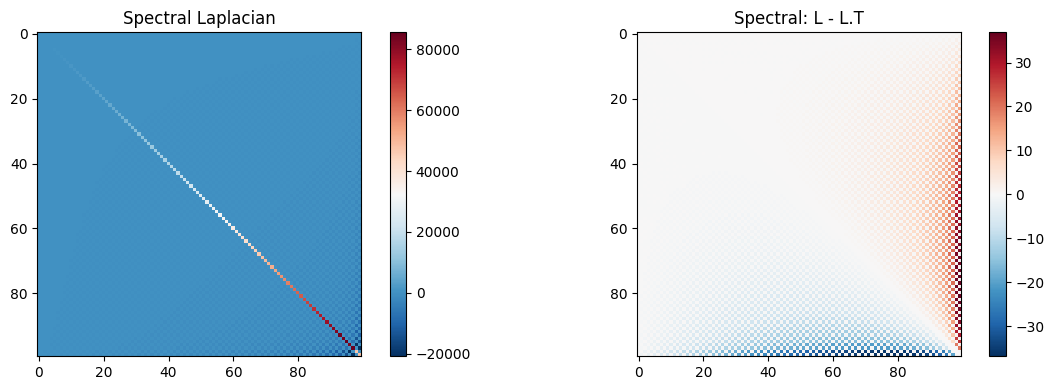

In [11]:
# Fix: Use spectral method instead of FD for spectral basis
int_cfg = IntegrationConfig(method='trapz', n_points=1000)
L_spectral = Laplacian(M, bcs, 1, method='spectral', dofs=100, integration_config=int_cfg)
L_spectral_mat = L_spectral.matrix(dense=True, galerkin=False, parallel=True, n_jobs=8)

print("Spectral method symmetry check:", np.allclose(L_spectral_mat, L_spectral_mat.T))
asymmetry_spectral = np.max(np.abs(L_spectral_mat - L_spectral_mat.T))
print(f"Max asymmetry (spectral): {asymmetry_spectral:.2e}")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(L_spectral_mat, cmap='RdBu_r')
plt.title('Spectral Laplacian')
plt.colorbar()
plt.subplot(122)
plt.imshow(L_spectral_mat - L_spectral_mat.T, cmap='RdBu_r')
plt.title('Spectral: L - L.T')
plt.colorbar()
plt.tight_layout()
plt.show()